In [877]:
from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash
from datetime import datetime, timedelta
import pytz # Thư viện để xử lý múi giờ

pd.set_option('display.max_columns', None)

In [589]:
# Establish connection to Elasticsearch
conn = Elasticsearch(
    # ['https://192.168.145.101:9200'], 
    ['http://localhost:9200'],
    # ca_certs=False, 
    # verify_certs=False,
    # basic_auth=('jupyter', 'jupyter@seconi.com'),
    # basic_auth=('nialliceh@gmail.com', 'nialliceh3108'),
    basic_auth=('analyzer_internal', 'analyzer'),
)

print(conn.info())
# print(conn.indices.get_data_stream(name="logs-zeek*"))

{'name': 'elasticsearch', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'Pu_iQyxxRKaCyWAkyvdUmA', 'version': {'number': '9.1.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'ca1a70216fbdefbef3c65b1dff04903ea5964ef5', 'build_date': '2025-08-11T15:04:41.449624592Z', 'build_snapshot': False, 'lucene_version': '10.2.2', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'}


In [878]:
# --- Search across all filebeat Zeek indices ---
zlog = Search(using=conn, index="filebeat-*")

# --- Define Zeek datasets ---
datasets = {
    "conn": "zeek.connection",
    "http": "zeek.http",
    "dns": "zeek.dns",
    "ssl": "zeek.ssl"
}

# 1. Định nghĩa múi giờ của bạn (Việt Nam, UTC+7)
local_tz = pytz.timezone("Asia/Ho_Chi_Minh")

# 2. Định nghĩa thời gian bắt đầu và kết thúc một cách tường minh
# Timestamp A: 23h ngày 6/10/2025 (UTC+7)
start_time_local = local_tz.localize(datetime(2025, 10, 6, 23, 0, 0))

# Timestamp B: 8h ngày 7/10/2025 (UTC+7)
end_time_local = local_tz.localize(datetime(2025, 10, 7, 8, 0, 0))

print(f"Querying data from {start_time_local.isoformat()} to {end_time_local.isoformat()}")


dfs = {}  # store DataFrames for each type

for name, dataset in datasets.items():
    print(f"Fetching {dataset} logs...")

    query = (
        zlog.query("term", **{"event.dataset": dataset})
            .filter("range", **{
                "@timestamp": {
                    "gte": start_time_local.isoformat(),
                    "lt": end_time_local.isoformat()
                }
            })
    )

    # Collect results
    rows = []
    for hit in query.scan():
        doc = hit.to_dict()
        rows.append(doc)   # keep full parsed document (all ECS + Zeek fields)

    # Convert to DataFrame
    if rows:
        df = pd.json_normalize(rows, sep='.')
        dfs[name] = df
        print(f"✅ {dataset}: {len(df)} rows, {len(df.columns)} columns")
    else:
        print(f"⚠️ {dataset}: no data found")

for name, df in dfs.items():
    df['@timestamp'] = pd.to_datetime(df['@timestamp']).dt.tz_convert('Asia/Bangkok')
    df['ts'] = df['@timestamp'].astype('int64') / 1e9

Querying data from 2025-10-06T23:00:00+07:00 to 2025-10-07T08:00:00+07:00
Fetching zeek.connection logs...
✅ zeek.connection: 5512 rows, 60 columns
Fetching zeek.http logs...
✅ zeek.http: 69 rows, 67 columns
Fetching zeek.dns logs...
✅ zeek.dns: 1556 rows, 65 columns
Fetching zeek.ssl logs...
✅ zeek.ssl: 3492 rows, 65 columns


In [879]:
# convert to zeek log format

conn_df = dfs['conn'][['ts', 'source.ip', 'destination.ip', 'destination.port', 'event.duration', 'source.bytes']]
# rename columns for clarity
conn_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'id.resp_p', 'duration', 'orig_ip_bytes']
conn_df.head()


ssl_df = dfs['ssl'][['ts', 'source.ip', 'destination.ip', 'zeek.ssl.sni_matches_cert', 'zeek.ssl.server.name', 'tls.client.ja3']]
ssl_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'sni_matches_cert', 'server_name', 'ja3']
ssl_df.head()

http_df = dfs['http'][['ts', 'source.ip', 'destination.ip', 'url.domain', 'http.response.body.bytes', 'user_agent.original']]
http_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'host', 'response_body_len', 'user_agent']
http_df.head()

dns_df = dfs['dns'][['ts', 'source.ip', 'destination.ip', 'zeek.dns.query', 'zeek.dns.qtype_name', 'zeek.dns.rcode_name']]
dns_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'query', 'qtype_name', 'rcode_name']
dns_df.head()

,ts,id.orig_h,id.resp_h,query,qtype_name,rcode_name
0,1.759798e+09,192.168.28.129,192.168.28.2,array601.prod.do.dsp.mp.microsoft.com,A,NOERROR
1,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
2,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
3,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
4,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN


In [ ]:
# Read log from Elasticsearch to DataFrame

zlog = Search(using=conn, index='logs-zeek-so')

conn_log = zlog.query("term", **{"event.dataset": "zeek.conn"})
http_log = zlog.query("term", **{"event.dataset": "zeek.http"})
dns_log = zlog.query("term", **{"event.dataset": "zeek.dns"})
ssl_log = zlog.query("term", **{"event.dataset": "zeek.ssl"})

conn_12h = conn_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
http_12h = http_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
dns_12h = dns_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
ssl_12h = ssl_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})

conn_df = pd.DataFrame()
for hit in conn_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    conn_df = pd.concat([conn_df, row], ignore_index=True)

http_df = pd.DataFrame()
for hit in http_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    http_df = pd.concat([http_df, row], ignore_index=True)

dns_df = pd.DataFrame()
for hit in dns_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    dns_df = pd.concat([dns_df, row], ignore_index=True)

ssl_df = pd.DataFrame()
for hit in ssl_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    ssl_df = pd.concat([ssl_df, row], ignore_index=True)


{'agent': {'name': 'filebeat', 'id': 'b00d24eb-8a08-4ef1-ace4-85f49d5c8c94', 'ephemeral_id': 'a44f3633-d89d-4376-96e0-40090bfed890', 'type': 'filebeat', 'version': '9.1.2'}, 'log': {'file': {'path': '/var/log/zeek/http.log'}, 'offset': 1055975}, 'destination': {'geo': {'continent_name': 'Asia', 'city_name': 'Singapore', 'country_iso_code': 'SG', 'country_name': 'Singapore', 'location': {'lat': 1.2872, 'lon': 103.8507}}, 'as': {'number': 54113, 'organization': {'name': 'FASTLY'}}, 'address': '146.75.46.172', 'port': 80, 'ip': '146.75.46.172'}, 'zeek': {'http': {'trans_depth': 12, 'status_msg': 'Partial Content', 'tags': []}, 'session_id': 'CjLgvl2UX4A7STeRia'}, 'source': {'address': '192.168.28.129', 'port': 50266, 'ip': '192.168.28.129'}, 'fileset': {'name': 'http'}, 'url': {'original': '/filestreamingservice/files/ed5bb7bb-8642-4a7e-8505-551f1f122223?P1=1759772356&P2=404&P3=2&P4=G1CRyKvv2iWE11D/esv5gHkU1L/zDaj2ZjbLn/jCA+WolyDO5c3jOAO8JmXak+NwtyVp3WaHOP0Ewop3n4mlAw==', 'port': 80, 'dom

KeyError: 'message'

In [36]:
# write dataframe to csv file
conn_df.to_csv('zeek_conn_12h.csv', index=False)
http_df.to_csv('zeek_http_12h.csv', index=False)
dns_df.to_csv('zeek_dns_12h.csv', index=False)
ssl_df.to_csv('zeek_ssl_12h.csv', index=False)

### Start from here if not running SecOni

In [397]:
# read csv file to dataframe
conn_df = pd.read_csv('zeek_conn_12h.csv')
http_df = pd.read_csv('zeek_http_12h.csv')
dns_df = pd.read_csv('zeek_dns_12h.csv')
ssl_df = pd.read_csv('zeek_ssl_12h.csv')

In [366]:
# Đọc file log Zeek vào DataFrame
def read_zeek_log(file_path):
    # Lấy tên cột từ dòng "#fields"
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                columns = line.strip().split("\t")[1:]  # bỏ "#fields"
                break

    # Đọc dữ liệu, bỏ các dòng metadata
    df = pd.read_csv(
        file_path,
        sep="\t",
        comment="#",      # bỏ các dòng bắt đầu bằng "#"
        names=columns,    # dùng tên cột lấy từ #fields
        na_values=["-"],  # thay "-" bằng NaN
    )
    return df

path = "./../traffic/log/taidoor/"

conn_df = read_zeek_log(path + "conn.log")
http_df = read_zeek_log(path + "http.log")
dns_df = read_zeek_log(path + "dns.log")
ssl_df = read_zeek_log(path + "ssl.log")
# x509_df = read_zeek_log(path + "x509.log")

# start analyse

In [809]:
tmp_dfs = dfs['ssl']
tmp_dfs[(tmp_dfs['source.ip'] == '192.168.28.129') & (tmp_dfs['destination.ip'] == '192.168.20.100')]

,tags,@timestamp,server.address,agent.name,agent.id,agent.ephemeral_id,agent.type,agent.version,log.file.path,log.offset,destination.address,destination.port,destination.ip,zeek.session_id,zeek.ssl.established,zeek.ssl.cipher,zeek.ssl.curve,zeek.ssl.ssl_history,zeek.ssl.resumed,zeek.ssl.version,source.address,source.port,source.ip,fileset.name,network.community_id,network.transport,network.direction,input.type,ecs.version,related.ip,service.type,host.name,client.address,tls.cipher,tls.established,tls.server.ja3s,tls.curve,tls.client.ja3,tls.resumed,tls.version,tls.version_protocol,event.ingested,event.kind,event.created,event.module,event.id,event.type,event.category,event.dataset,destination.geo.continent_name,destination.geo.region_iso_code,destination.geo.city_name,destination.geo.country_iso_code,destination.geo.country_name,destination.geo.location.lat,destination.geo.location.lon,destination.geo.region_name,destination.as.number,destination.as.organization.name,zeek.ssl.server.name,zeek.ssl.sni_matches_cert,zeek.ssl.next_protocol,zeek.ssl.client_cert_chain_fps,zeek.ssl.cert_chain_fps,zeek.ssl.validation.status,ts
0,[zeek.ssl],2025-10-07 07:54:11.856000+07:00,192.168.20.100,filebeat,b00d24eb-8a08-4ef1-ace4-85f49d5c8c94,a52e710f-3c8d-4792-9f04-9358416bf1d4,filebeat,9.1.2,/var/log/zeek/ssl.log,237500,192.168.20.100,8081,192.168.20.100,COfhlo1s0fo3K2cNQf,True,TLS_AES_128_GCM_SHA256,x25519,CsiI,False,TLSv13,192.168.28.129,51316,192.168.28.129,ssl,1:1uRrqxBSS1tS79Kxf5ZMUqQJdzg=,tcp,internal,log,1.12.0,"[192.168.28.129, 192.168.20.100]",zeek,filebeat,192.168.28.129,TLS_AES_128_GCM_SHA256,True,f4febc55ea12b31ae17cfb7e614afda8,x25519,19e29534fd49dd27d09234e639c4057e,False,1.3,tls,2025-10-07T00:54:22.320630774Z,event,2025-10-07T00:54:12.315Z,zeek,COfhlo1s0fo3K2cNQf,"[connection, protocol]",[network],zeek.ssl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759798e+09
1,[zeek.ssl],2025-10-07 07:54:17.198000+07:00,192.168.20.100,filebeat,b00d24eb-8a08-4ef1-ace4-85f49d5c8c94,a52e710f-3c8d-4792-9f04-9358416bf1d4,filebeat,9.1.2,/var/log/zeek/ssl.log,237854,192.168.20.100,8081,192.168.20.100,CMYAaW3vh0nuwAWiN9,True,TLS_AES_128_GCM_SHA256,x25519,CsiI,False,TLSv13,192.168.28.129,51317,192.168.28.129,ssl,1:NnCXfmjmoYUg3sRx78su6K8rAPQ=,tcp,internal,log,1.12.0,"[192.168.28.129, 192.168.20.100]",zeek,filebeat,192.168.28.129,TLS_AES_128_GCM_SHA256,True,f4febc55ea12b31ae17cfb7e614afda8,x25519,19e29534fd49dd27d09234e639c4057e,False,1.3,tls,2025-10-07T00:54:22.321251058Z,event,2025-10-07T00:54:19.318Z,zeek,CMYAaW3vh0nuwAWiN9,"[connection, protocol]",[network],zeek.ssl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759798e+09
2,[zeek.ssl],2025-10-07 07:54:23.921000+07:00,192.168.20.100,filebeat,b00d24eb-8a08-4ef1-ace4-85f49d5c8c94,a52e710f-3c8d-4792-9f04-9358416bf1d4,filebeat,9.1.2,/var/log/zeek/ssl.log,238206,192.168.20.100,8081,192.168.20.100,Ch0D71o89tC5b8mmh,True,TLS_AES_128_GCM_SHA256,x25519,CsiI,False,TLSv13,192.168.28.129,51318,192.168.28.129,ssl,1:slBdXO0TqqKBNh1Q+TRUsxGw5m4=,tcp,internal,log,1.12.0,"[192.168.28.129, 192.168.20.100]",zeek,filebeat,192.168.28.129,TLS_AES_128_GCM_SHA256,True,f4febc55ea12b31ae17cfb7e614afda8,x25519,19e29534fd49dd27d09234e639c4057e,False,1.3,tls,2025-10-07T00:54:34.494951048Z,event,2025-10-07T00:54:26.321Z,zeek,Ch0D71o89tC5b8mmh,"[connection, protocol]",[network],zeek.ssl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759798e+09
3,[zeek.ssl],2025-10-07 07:54:30.987000+07:00,192.168.20.100,filebeat,b00d24eb-8a08-4ef1-ace4-85f49d5c8c94,a52e710f-3c8d-4792-9f04-9358416bf1d4,filebeat,9.1.2,/var/log/zeek/ssl.log,238559,192.168.20.100,8081,192.168.20.100,CGCz7w2B5EiOYDV8B4,True,TLS_AES_128_GCM_SHA256,x25519,CsiI,False,TLSv13,192.168.28.129,51319,192.168.28.129,ssl,1:70YoHniU+RubWH1kbtTeZkcRBKI=,tcp,internal,log,1.12.0,"[192.168.28.129, 192.168.20.100]",zeek,filebeat,192.168.28.129,TLS_AES_128_GCM_SHA256,True,f4febc55ea12b31ae17cfb7e614afda8,x25519,19e29534fd49dd2

In [790]:
conn_df[(conn_df['id.orig_h'] == '192.168.28.129') & (conn_df['id.resp_h'] == '192.168.20.100')]

,ts,id.orig_h,id.resp_h,id.resp_p,duration,orig_ip_bytes
2,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.062198e+09,1322
3,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.067019e+09,1322
7,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.066082e+09,1323
8,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.055162e+09,1322
9,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.061916e+09,1322
...,...,...,...,...,...,...
5496,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.066853e+09,1323
5497,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.066710e+09,1323
5500,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.068484e+09,1322
5503,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.091488e+09,1321


# conn.log

In [791]:
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]
conn_df

,ts,id.orig_h,id.resp_h,id.resp_p,duration,orig_ip_bytes
0,1.759781e+09,192.168.28.129,4.213.25.241,443.0,2.000388e+13,9546
1,1.759799e+09,192.168.28.129,27.67.51.50,443.0,9.590442e+11,17571
2,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.062198e+09,1322
3,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.067019e+09,1322
4,1.759798e+09,192.168.28.129,192.168.28.2,53.0,7.430792e+06,58
...,...,...,...,...,...,...
5507,1.759794e+09,192.168.28.1,239.255.255.250,1900.0,3.002357e+09,804
5508,1.759794e+09,192.168.28.129,20.189.173.6,443.0,9.450050e+09,44413
5509,1.759794e+09,192.168.28.129,13.89.179.13,443.0,1.105389e+10,9354
5510,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.085080e+09,1322


In [792]:
# 2. check common port
common_ports = {80, 443, 53, 22, 25, 21, 5353}

conn_df['rare_port'] = conn_df['id.resp_p'].apply(lambda x: 0 if x in common_ports else 1)
conn_df

,ts,id.orig_h,id.resp_h,id.resp_p,duration,orig_ip_bytes,rare_port
0,1.759781e+09,192.168.28.129,4.213.25.241,443.0,2.000388e+13,9546,0
1,1.759799e+09,192.168.28.129,27.67.51.50,443.0,9.590442e+11,17571,0
2,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.062198e+09,1322,1
3,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.067019e+09,1322,1
4,1.759798e+09,192.168.28.129,192.168.28.2,53.0,7.430792e+06,58,0
...,...,...,...,...,...,...,...
5507,1.759794e+09,192.168.28.1,239.255.255.250,1900.0,3.002357e+09,804,1
5508,1.759794e+09,192.168.28.129,20.189.173.6,443.0,9.450050e+09,44413,0
5509,1.759794e+09,192.168.28.129,13.89.179.13,443.0,1.105389e+10,9354,0
5510,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.085080e+09,1322,1


In [793]:
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h', 'id.resp_p'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'dstPort': name[2],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': [v for v in group['duration'].tolist() if pd.notna(v)],
        'rare_port': max(group['rare_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)
grcon_df

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port
0,0.0.0.0,255.255.255.255,67.0,[1759780792.2489998],[350],[],1
1,192.168.20.81,192.168.28.129,49235.0,[1759786174.1139998],[40],[],1
2,192.168.20.81,192.168.28.129,49236.0,[1759786174.1139998],[40],[],1
3,192.168.20.81,192.168.28.129,49435.0,[1759787382.4339998],[40],[],1
4,192.168.20.81,192.168.28.129,49436.0,[1759787382.4339998],[40],[],1
...,...,...,...,...,...,...,...
216,fe80::6d9f:7800:3b30:3f76,ff02::1:2,547.0,[1759780792.2910001],[1144],[64110574961.0],1
217,fe80::6d9f:7800:3b30:3f76,ff02::1:3,5355.0,"[1759778211.225, 1759779111.257, 1759780011.32...","[81, 81, 81, 162, 162, 81, 81, 81, 81, 81, 81,...","[421327114.0, 428045988.0]",1
218,fe80::6d9f:7800:3b30:3f76,ff02::c,1900.0,[1759780795.775],[572],[5921873093.0],1
219,fe80::6d9f:7800:3b30:3f76,ff02::c,3702.0,"[1759780516.8049998, 1759780793.671, 175978079...","[1640, 4560, 2688]","[74282885.0, 686932087.0, 5481935024.0]",1


In [794]:
# 3. check IoC list for dstIP
with open('ioc_ip.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'ip_ioc'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, 0)

In [795]:
# Calc Bowkey skewness and Median Absolute Deviation

# --- Lọc outlier bằng IQR ---
def remove_outliers_iqr(data, factor=1.5):
    if len(data) < 5:
        return np.array(data)
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return data[(data >= lower) & (data <= upper)]

# --- Tính độ lệch Bowley (mức độ đối xứng của phân phối) ---
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    if (q3 - q1) == 0:
        return 1.0
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)
    score = 1 - abs(bowley_skewness)  # 1 là đối xứng hoàn hảo
    return score

# --- Tính MAD (độ phân tán quanh trung vị) ---
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    cv_mad = mad / median if median != 0 else 0
    score = 1.0 / (1.0 + cv_mad)  # 1 là ổn định tuyệt đối
    return score

# --- Hàm tổng hợp theo cửa sổ (window-based) ---
def rolling_score(data, func, window_size=20, agg="median"):
    if len(data) < window_size:
        return func(np.array(data))
    
    scores = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = np.array(data[i:i+window_size])
        score = func(window)
        scores.append(score)
    
    if len(scores) == 0:
        return 0.0

    if agg == "median":
        return np.median(scores)
    elif agg == "mean":
        return np.mean(scores)
    elif agg == "max":
        return np.max(scores)
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'")

# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(data: list) -> float:
    if len(data) < 5:
        return 0.0
    
    data = remove_outliers_iqr(np.array(data))

    if len(data) < 2 or np.var(data) == 0:
        return 1 # beacon deu

    nlags = len(data) // 2

    try:
        autocorr_values = acf(data, nlags=nlags, fft=True)
        autocorr_values = np.nan_to_num(autocorr_values, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        return 0.0

    if len(autocorr_values) < 2:
        return 0.0

    score = np.max(np.clip(autocorr_values[1:], 0, 1))  # chỉ quan tâm lag > 0
    return score

In [781]:
# save row with timeList length < 5 for the next analysis
save_df = grcon_df[grcon_df['timeList'].apply(len) < 5]
save_df.to_csv('conn_next_batch.csv', index=False)

In [796]:
# Calc features

def ts_to_interval(ts):
    return np.diff(ts)

# # time features
# grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: calc_bowley_skewness(ts_to_interval(x)))
# grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: calc_median_absolute_deviation(ts_to_interval(x)))
# grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: calc_autocorrelation_v2(ts_to_interval(x)))

# # data features
# grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: calc_bowley_skewness(x))
# grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: calc_median_absolute_deviation(x))

# # duration features
# grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: calc_bowley_skewness(x))
# grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: calc_median_absolute_deviation(x))

grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['data_acf'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['dur_acf'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port,ip_ioc,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf,dur_bskew,dur_mad,dur_acf
0,0.0.0.0,255.255.255.255,67.0,[1759780792.2489998],[350],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,192.168.20.81,192.168.28.129,49235.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,192.168.20.81,192.168.28.129,49236.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,192.168.20.81,192.168.28.129,49435.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,192.168.20.81,192.168.28.129,49436.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,fe80::6d9f:7800:3b30:3f76,ff02::1:2,547.0,[1759780792.2910001],[1144],[64110574961.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
217,fe80::6d9f:7800:3b30:3f76,ff02::1:3,5355.0,"[1759778211.225, 1759779111.257, 1759780011.32...","[81, 81, 81, 162, 162, 81, 81, 81, 81, 81, 81,...","[421327114.0, 428045988.0]",1,0,0.000120,0.999896,0.209558,1.0,1.0,1.000000,0.000000,0.000000,0.000000
218,fe80::6d9f:7800:3b30:3f76,ff02::c,1900.0,[1759780795.775],[572],[5921873093.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
219,fe80::6d9f:7800:3b30:3f76,ff02::c,3702.0,"[1759780516.8049998, 1759780793.671, 175978079...","[1640, 4560, 2688]","[74282885.0, 686932087.0, 5481935024.0]",1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [798]:
grcon_df[(grcon_df['srcIP'] == '192.168.28.129') & (grcon_df['dstIP'] == '192.168.20.100')]

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port,ip_ioc,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf,dur_bskew,dur_mad,dur_acf
128,192.168.28.129,192.168.20.100,8000.0,"[1759781274.631, 1759781274.724, 1759781291.48...","[700, 608, 686, 57713, 48220, 686, 70875, 377]","[214205027.0, 194643974.0, 16716003.0, 1634026...",1,0,0.084211,0.519650,0.000000,0.001062,0.775602,0.042276,0.164368,0.566587,0.386404
129,192.168.28.129,192.168.20.100,8081.0,"[1759781650.289, 1759781651.328, 1759781658.97...","[1659, 1322, 1322, 1322, 1630, 1533, 233390, 1...","[1039355993.0, 1049757957.0, 1046146870.0, 105...",1,0,0.829145,0.905252,0.237126,0.400000,1.000000,0.314286,0.762586,0.995598,0.246288


In [799]:
# merge grcon_df to final_df
final_con = grcon_df.groupby(['srcIP', 'dstIP']).agg({
    'time_bskew': 'max',
    'time_mad': 'max',
    'time_acf': 'max',
    'data_bskew': 'max',
    'data_mad': 'max',
    'dur_bskew': 'max',
    'dur_mad': 'max',
    'rare_port': 'max',
    'ip_ioc': 'max',
}).reset_index()
# final_con.set_index(['srcIP', 'dstIP'], inplace=True)
final_con['time_score'] = final_con[['time_bskew', 'time_mad', 'time_acf']].mean(axis=1)
final_con['data_score'] = final_con[['data_bskew', 'data_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_bskew', 'dur_mad']].mean(axis=1)
final_con['conn_score'] = final_con[['time_score', 'data_score']].mean(axis=1)
# if dur_score > 0.6, increase final_score by 10% as a bonus, but not exceed 1.0
final_con['conn_score'] = np.where(final_con['dur_score'] > 0.6, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['rare_port'] == 1, final_con['conn_score'] * 1.1, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['ip_ioc'] == 1, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = final_con['conn_score'].clip(upper=1.0)
# only keep important columns
final_con = final_con[['srcIP', 'dstIP', 'conn_score', 'rare_port', 'ip_ioc']]
final_con
final_con[(final_con['srcIP'] == '192.168.28.129') & (final_con['dstIP'] == '192.168.20.100')]


,srcIP,dstIP,conn_score,rare_port,ip_ioc
99,192.168.28.129,192.168.20.100,0.895735,1,0


# ssl.log

In [ ]:
a = ssl_df[(ssl_df['id.orig_h'] == '192.168.28.129') & (ssl_df['id.resp_h'] == '192.168.20.100')]['server_name']

np.int64(2627)

In [830]:
# 3. check JA3
with open('ioc_ja3.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)

/tmp/ipykernel_1251063/3123270239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)


In [831]:
# group by srcIP, dstIP
rows = []
ssl_df = ssl_df.sort_values(by=['ts'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'sni_matches_cert': max(group['sni_matches_cert'].tolist()),
    })
grssl_df = pd.DataFrame(rows)
grssl_df.set_index(['srcIP', 'dstIP'], inplace=True)

for index, row in ssl_df.iterrows():
    if pd.isna(row['sni_matches_cert']):
        ssl_df.at[index, 'sni_matches_cert'] = grssl_df.loc[(row['id.orig_h'], row['id.resp_h']), 'sni_matches_cert']

In [863]:
ssl_df[ssl_df['server_name'] == 'www.youtube.com']

,ts,id.orig_h,id.resp_h,sni_matches_cert,server_name,ja3,ja3_ioc,sni_not_matches_cert
892,1.759778e+09,192.168.28.129,142.250.76.14,NaN,www.youtube.com,20b9d156362559264652e7ad1327e91d,0,0
898,1.759778e+09,192.168.28.129,142.250.76.14,NaN,www.youtube.com,3435d0676829dee656ac450c65551dd1,0,0
900,1.759778e+09,192.168.28.129,142.250.199.238,NaN,www.youtube.com,4d4ba01a00a61e60eeae010b804c6f63,0,0
903,1.759778e+09,192.168.28.129,142.250.199.238,NaN,www.youtube.com,b391993383ea4397bd0a4c5c470176fe,0,0
905,1.759778e+09,192.168.28.129,142.250.199.238,NaN,www.youtube.com,499d6f5be31a08966d4d7012a5f488e6,0,0
...,...,...,...,...,...,...,...,...
82,1.759798e+09,192.168.28.129,142.250.198.238,NaN,www.youtube.com,26c02a2bd1fa094506eaa1b0617ae8e8,0,0
88,1.759798e+09,192.168.28.129,142.250.198.238,NaN,www.youtube.com,589d8e712fc51e0c40564cbe8fdb7578,0,0
101,1.759798e+09,192.168.28.129,142.250.198.238,NaN,www.youtube.com,45ae6c4d41fae6377585889092a9aa27,0,0
131,1.759798e+09,192.168.28.129,142.250.198.238,NaN,www.youtube.com,f213e200ef9fae4266c8695e602abcc3,0,0


In [833]:
# 4. check SNI
# ssl_df.loc[:, 'sni_not_matched_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

SAFE_DOMAINS = [
    'google.com','gstatic.com','youtube.com','ggpht.com',
    'microsoft.com','windowsupdate.com','office.com','msftconnecttest.com',
    'apple.com','icloud.com','mzstatic.com',
    'facebook.com','fbcdn.net','instagram.com','whatsapp.net',
    'cloudflare.com','cdn.cloudflare.net',
    'dns.google','quad9.net','a.root-servers.net','b.root-servers.net','c.root-servers.net',
    'd.root-servers.net','e.root-servers.net','f.root-servers.net','g.root-servers.net',
    'h.root-servers.net','i.root-servers.net','j.root-servers.net','k.root-servers.net',
    'l.root-servers.net','m.root-servers.net'
] # service that not likely to be used for domain fronting

ssl_df = ssl_df[~(
    (ssl_df['sni_matches_cert'] == True) &
    (ssl_df['server_name'].apply(lambda x: extract_domain(x)).isin(SAFE_DOMAINS))
)]

In [ ]:
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_df[(ssl_df['id.orig_h'] == '192.168.28.129') & (ssl_df['id.resp_h'] == '192.168.20.100')]

,ts,id.orig_h,id.resp_h,sni_matches_cert,server_name,ja3,ja3_ioc
1046,1.759782e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
1047,1.759782e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
1048,1.759782e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
1049,1.759782e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
1050,1.759782e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
...,...,...,...,...,...,...,...
70,1.759799e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
72,1.759799e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
73,1.759799e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0
74,1.759799e+09,192.168.28.129,192.168.20.100,NaN,192.168.20.100,19e29534fd49dd27d09234e639c4057e,0


In [852]:
ssl_df.loc[1046, 'sni_matches_cert'] == False

False

In [858]:
# group by srcIP, server_name, sni_not_matched_cert
rows = []
ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

ssl_df = ssl_df.sort_values(by=['ts'])
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'server_name', 'sni_not_matches_cert'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'server_name': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'ja3_ioc': max(group['ja3_ioc'].tolist()),
        'sni_not_matched_cert': name[2],
    })
grssl_df = pd.DataFrame(rows)
grssl_df[grssl_df['server_name'] == '192.168.20.100']

,srcIP,server_name,dstIPList,timeList,ja3_ioc,sni_not_matched_cert
0,192.168.28.129,192.168.20.100,[192.168.20.100],"[1759781650.29, 1759781651.33, 1759781658.973,...",0,0


In [859]:
# Calc features
grssl_df['time_bskew'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grssl_df['time_mad'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grssl_df['time_acf'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grssl_df

,srcIP,server_name,dstIPList,timeList,ja3_ioc,sni_not_matched_cert,time_bskew,time_mad,time_acf
0,192.168.28.129,192.168.20.100,[192.168.20.100],"[1759781650.29, 1759781651.33, 1759781658.973,...",0,0,0.829849,0.905001,0.238134
1,192.168.28.129,9469210.fls.doubleclick.net,[142.250.71.230],"[1759781888.9190001, 1759781889.176]",0,0,0.000000,0.000000,0.000000
2,192.168.28.129,accounts.google.com,[74.125.130.84],[1759781888.591],0,0,0.000000,0.000000,0.000000
3,192.168.28.129,accounts.shopee.co.id,[202.181.90.190],"[1759781911.021, 1759781911.022]",0,0,0.000000,0.000000,0.000000
4,192.168.28.129,ad-log.dable.io,[43.200.77.115],[1759781259.675],0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,192.168.28.129,www.googleadservices.com,[142.250.71.162],[1759778703.3660002],0,0,0.000000,0.000000,0.000000
96,192.168.28.129,www.googletagmanager.com,[142.250.76.8],"[1759781884.451, 1759781885.1820002, 175978188...",0,0,0.000000,0.000000,0.000000
97,192.168.28.129,www.gstatic.com,[142.250.198.35],"[1759781836.345, 1759781853.492]",0,0,0.000000,0.000000,0.000000
98,192.168.28.129,www.youtube.com,"[142.250.71.142, 142.250.76.14, 142.250.76.238...","[1759777783.3379998, 1759777823.05, 1759777863...",0,0,0.731157,0.999563,0.304592


In [862]:
# merge grssl_df to final_ssl
# get max of mean(time_bskew, time_mad) and time_acf
grssl_df['ssl_score'] = grssl_df[['time_bskew', 'time_mad']].mean(axis=1)
grssl_df['ssl_score'] = grssl_df[['ssl_score', 'time_acf']].max(axis=1)
# if ja3_ioc == 1, increase ssl_score by 20% as a bonus, but not exceed 1.0
grssl_df['ssl_score'] = np.where(grssl_df['ja3_ioc'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = np.where(grssl_df['sni_not_matched_cert'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = grssl_df['ssl_score'].clip(upper=1.0)
grssl_df

final_ssl = grssl_df.explode('dstIPList', ignore_index=True)
final_ssl = final_ssl.rename(columns={'dstIPList': 'dstIP'})
# final_ssl.set_index(['srcIP', 'dstIP'], inplace=True)
final_ssl = final_ssl[['srcIP', 'dstIP', 'ssl_score', 'ja3_ioc', 'sni_not_matched_cert']]
final_ssl

,srcIP,dstIP,ssl_score,ja3_ioc,sni_not_matched_cert
0,192.168.28.129,192.168.20.100,0.867425,0,0
1,192.168.28.129,142.250.71.230,0.000000,0,0
2,192.168.28.129,74.125.130.84,0.000000,0,0
3,192.168.28.129,202.181.90.190,0.000000,0,0
4,192.168.28.129,43.200.77.115,0.000000,0,0
...,...,...,...,...,...
148,192.168.28.129,142.250.197.142,0.865360,0,0
149,192.168.28.129,142.250.71.238,0.865360,0,0
150,192.168.28.129,142.250.198.142,0.865360,0,0
151,192.168.28.129,142.250.71.206,0.865360,0,0


# http.log

In [866]:
# check User-Agent
http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)
http_df

,ts,id.orig_h,id.resp_h,host,response_body_len,user_agent,null_user_agent
16,1.759778e+09,192.168.28.129,125.235.36.170,ctldl.windowsupdate.com,0,Microsoft-CryptoAPI/10.0,0
17,1.759778e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,0,Microsoft BITS/7.8,0
18,1.759778e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,1120,Microsoft BITS/7.8,0
19,1.759778e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,1347,Microsoft BITS/7.8,0
20,1.759778e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,4500,Microsoft BITS/7.8,0
...,...,...,...,...,...,...,...
8,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,28580,Microsoft BITS/7.8,0
9,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,59181,Microsoft BITS/7.8,0
10,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,120202,Microsoft BITS/7.8,0
11,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,239062,Microsoft BITS/7.8,0


In [875]:
# group by srcIP, Host
rows = []
http_df = http_df.sort_values(by=['ts'])
http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
http_grouped = http_df.groupby(['id.orig_h', 'host'])
for name, group in http_grouped:
    rows.append({
        'srcIP': name[0],
        'host': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'dataList': group['response_body_len'].tolist(),
        'null_user_agent': 1 if pd.isna(group['user_agent']).any() else 0
    })
grhttp_df = pd.DataFrame(rows)
grhttp_df

,srcIP,host,dstIPList,timeList,dataList,null_user_agent
0,192.168.28.129,192.168.20.100:8000,[192.168.20.100],"[1759781274.7900002, 1759781274.908, 175978129...","[1932, 335, 242, 15879168, 15879168, 301, 1603...",0
1,192.168.28.129,ctldl.windowsupdate.com,"[146.75.46.172, 125.235.36.170]","[1759777863.034, 1759778543.524, 1759780854.93...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,192.168.28.129,msedge.b.tlu.dl.delivery.mp.microsoft.com,[146.75.46.172],"[1759778489.9350002, 1759778490.039, 175977849...","[0, 1120, 1347, 4500, 10368, 6024, 0, 1120, 17...",0
3,192.168.28.129,ocsp.digicert.com,"[23.50.21.119, 23.66.33.52]","[1759780793.388, 1759780793.39, 1759780793.457...","[471, 314, 313, 314, 471, 311, 471, 471, 313]",0


In [867]:
# Calc features

# grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: calc_bowley_skewness(ts_to_interval(x)))
# grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: calc_median_absolute_deviation(ts_to_interval(x)))
# grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: calc_autocorrelation_v2(ts_to_interval(x)))
# grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: calc_bowley_skewness(x))
# grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: calc_median_absolute_deviation(x))
# grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: calc_autocorrelation_v2(x))
# grhttp_df


grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))
grhttp_df

,srcIP,host,dstIPList,timeList,dataList,null_user_agent,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf
0,192.168.28.129,192.168.20.100:8000,"[192.168.20.100, 192.168.20.100, 192.168.20.10...","[1759781274.7900002, 1759781274.908, 175978129...","[1932, 335, 242, 15879168, 15879168, 301, 1603...",0,0.000660,0.521177,0.534028,0.000203,0.533407,0.014708
1,192.168.28.129,ctldl.windowsupdate.com,"[125.235.36.170, 125.235.36.170, 125.235.36.17...","[1759777863.034, 1759778543.524, 1759780854.93...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.389769,0.624130,0.796278,1.000000,1.000000,1.000000
2,192.168.28.129,msedge.b.tlu.dl.delivery.mp.microsoft.com,"[146.75.46.172, 146.75.46.172, 146.75.46.172, ...","[1759778489.9350002, 1759778490.039, 175977849...","[0, 1120, 1347, 4500, 10368, 6024, 0, 1120, 17...",0,0.121599,0.811976,0.179031,0.686825,0.501048,0.342087
3,192.168.28.129,ocsp.digicert.com,"[23.66.33.52, 23.66.33.52, 23.66.33.52, 23.50....","[1759780793.388, 1759780793.39, 1759780793.457...","[471, 314, 313, 314, 471, 311, 471, 471, 313]",0,0.004646,0.500304,0.000000,0.012658,0.990536,0.000000


In [876]:
# merge grhttp_df to final_http

grhttp_df['http_score'] = (grhttp_df['time_bskew'] + grhttp_df['time_mad'] + grhttp_df['time_acf']) / 3
# if null_user_agent == 1, increase http_score by 20% as a bonus, but not exceed 1.0
grhttp_df['http_score'] = np.where(grhttp_df['null_user_agent'] == 1, grhttp_df['http_score'] * 1.2, grhttp_df['http_score'])
grhttp_df['http_score'] = grhttp_df['http_score'].clip(upper=1.0)

final_http = grhttp_df.explode('dstIPList', ignore_index=True)
final_http = final_http.rename(columns={'dstIPList': 'dstIP'})
# final_http.set_index(['srcIP', 'dstIP'], inplace=True)
final_http = final_http[['srcIP', 'dstIP', 'http_score', 'null_user_agent']]
final_http

KeyError: 'time_bskew'

# dns.log

In [870]:
# remove logs with nan query
dns_df = dns_df[~pd.isna(dns_df['query'])]
dns_df

,ts,id.orig_h,id.resp_h,query,qtype_name,rcode_name
0,1.759798e+09,192.168.28.129,192.168.28.2,array601.prod.do.dsp.mp.microsoft.com,A,NOERROR
1,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
2,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
3,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
4,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
...,...,...,...,...,...,...
1551,1.759794e+09,192.168.28.129,192.168.28.2,v10.events.data.microsoft.com,A,NOERROR
1552,1.759794e+09,192.168.28.129,192.168.28.2,v20.events.data.microsoft.com,A,NOERROR
1553,1.759794e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
1554,1.759794e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN


In [871]:
dns_df.loc[:, 'domain'] = dns_df['query'].apply(lambda x: extract_domain(x))

def extract_subdomain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[:-2]) if len(parts) > 2 else ''

# group by srcIP, domain
rows = []
dns_df = dns_df.sort_values(by=['ts'])
dns_grouped = dns_df.groupby(['id.orig_h', 'domain'])
for name, group in dns_grouped:
    rows.append({
        'srcIP': name[0],
        'domain': name[1],
        'timeList': group["ts"].tolist(),
        'subdmList': group['query'].apply(lambda x: extract_subdomain(x)).tolist(),
        '%TXT/CNAME': sum(group['qtype_name'].isin(['TXT', 'CNAME'])),
        '%NXDOMAIN': sum(group['rcode_name'] == 'NXDOMAIN'),
    })

grdns_df = pd.DataFrame(rows)
grdns_df['%TXT/CNAME'] = grdns_df['%TXT/CNAME'] / grdns_df['timeList'].apply(len)
grdns_df['%NXDOMAIN'] = grdns_df['%NXDOMAIN'] / grdns_df['timeList'].apply(len)
grdns_df['%unique_subdm'] = grdns_df['subdmList'].apply(lambda x: len(set(x))) / grdns_df['timeList'].apply(len)
grdns_df['dm_avg_len'] = grdns_df['subdmList'].apply(lambda x: np.mean([len(s) for s in x]) if len(x) > 0 else 0) + grdns_df['domain'].apply(lambda x: len(x))
grdns_df

,srcIP,domain,timeList,subdmList,%TXT/CNAME,%NXDOMAIN,%unique_subdm,dm_avg_len
0,192.168.28.1,_tcp.local,"[1759777884.912, 1759777884.912, 1759777885.91...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.045455,20.045455
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,"[1759781911.824, 1759781912.8270001, 175978194...","[, , ]",0.0,0.0,0.333333,42.000000
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,"[1759781913.839, 1759781914.832]","[, ]",0.0,0.0,0.500000,42.000000
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,"[1759781887.1529999, 1759781888.1590002, 17597...","[, , ]",0.0,0.0,0.333333,42.000000
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,"[1759781915.864, 1759781916.8339999]","[, ]",0.0,0.0,0.500000,42.000000
...,...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,"[1759780795.028, 1759780795.029, 1759780796.04...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.083333,21.000000
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,"[1759781889.156, 1759781890.164]","[, ]",0.0,0.0,0.500000,42.000000
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,"[1759781891.168, 1759781892.1699998]","[, ]",0.0,0.0,0.500000,42.000000
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,"[1759778211.225, 1759779111.257, 1759780011.32...","[, , , , , , , , , , , , , , , , , , , , , , ,...",0.0,0.0,0.027778,15.000000


In [872]:
# Calc features
grdns_df['time_bskew'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grdns_df['time_mad'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grdns_df['time_acf'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grdns_df

,srcIP,domain,timeList,subdmList,%TXT/CNAME,%NXDOMAIN,%unique_subdm,dm_avg_len,time_bskew,time_mad,time_acf
0,192.168.28.1,_tcp.local,"[1759777884.912, 1759777884.912, 1759777885.91...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.045455,20.045455,0.001499,0.500000,0.480974
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,"[1759781911.824, 1759781912.8270001, 175978194...","[, , ]",0.0,0.0,0.333333,42.000000,0.000000,0.000000,0.000000
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,"[1759781913.839, 1759781914.832]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,"[1759781887.1529999, 1759781888.1590002, 17597...","[, , ]",0.0,0.0,0.333333,42.000000,0.000000,0.000000,0.000000
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,"[1759781915.864, 1759781916.8339999]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,"[1759780795.028, 1759780795.029, 1759780796.04...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.083333,21.000000,0.001328,0.500000,0.564330
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,"[1759781889.156, 1759781890.164]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,"[1759781891.168, 1759781892.1699998]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,"[1759778211.225, 1759779111.257, 1759780011.32...","[, , , , , , , , , , , , , , , , , , , , , , ,...",0.0,0.0,0.027778,15.000000,0.003371,0.998271,0.140004


In [873]:
grdns_df['high_TXT/CNAME_ratio'] = np.where(grdns_df['%TXT/CNAME'] > 0.5, 1, 0)
grdns_df['high_NXDOMAIN_ratio'] = np.where(grdns_df['%NXDOMAIN'] > 0.5, 1, 0)
grdns_df['high_unique_subdm_ratio'] = np.where(grdns_df['%unique_subdm'] > 0.5, 1, 0)
grdns_df['long_dm_avg_len'] = np.where(grdns_df['dm_avg_len'] > 40, 1, 0)

grdns_df['dns_score'] = (grdns_df['time_bskew'] + grdns_df['time_mad'] + grdns_df['time_acf']) / 3
# if %TXT/CNAME > 0.5 and number of query > 10, increase dns_score by 10% as a bonus, but not exceed 1.0
grdns_df['dns_score'] = np.where(grdns_df['high_TXT/CNAME_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_NXDOMAIN_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_unique_subdm_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['long_dm_avg_len'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = grdns_df['dns_score'].clip(upper=1.0)

final_dns = grdns_df.explode('domain', ignore_index=True)
final_dns = final_dns.rename(columns={'domain': 'dstIP'})
# final_dns.set_index(['srcIP', 'dstIP'], inplace=True)
final_dns = final_dns[['srcIP', 'dstIP', 'dns_score', 'high_TXT/CNAME_ratio', 'high_NXDOMAIN_ratio', 'high_unique_subdm_ratio', 'long_dm_avg_len']]
final_dns

,srcIP,dstIP,dns_score,high_TXT/CNAME_ratio,high_NXDOMAIN_ratio,high_unique_subdm_ratio,long_dm_avg_len
0,192.168.28.1,_tcp.local,0.327491,0,0,0,0
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,0.000000,0,0,0,1
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,0.000000,0,0,0,1
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,0.000000,0,0,0,1
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,0.000000,0,0,0,1
...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,0.355219,0,0,0,0
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,0.000000,0,0,0,1
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,0.000000,0,0,0,1
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,0.380549,0,0,0,0


In [ ]:
def merge_with_reason(base_df, new_df, score_col, reason_map):
    """
    Hợp nhất DataFrame phát hiện beacon theo IP pair.
    - Giữ lại duy nhất một score_col.
    - Gộp reason nếu nhiều điều kiện match.
    """
    # Nếu base_df đã có score_col thì xóa (tránh sinh _x/_y)
    if score_col in base_df.columns:
        base_df = base_df.drop(columns=[score_col])

    # Merge theo IP pair
    merged = base_df.merge(
        new_df[['srcIP', 'dstIP', score_col] + list(reason_map.keys())],
        on=['srcIP', 'dstIP'],
        how='outer'
    )

    # Bổ sung cột reason nếu thiếu
    merged['reason'] = merged['reason'].fillna('')

    # Thêm mô tả vào reason nếu flag = 1
    for col, msg in reason_map.items():
        merged.loc[merged[col] == 1, 'reason'] = (
            merged['reason'].astype(str).str.strip() +
            np.where(merged['reason'].astype(bool), '; ', '') +
            msg
        )

    # Xóa cột flag sau khi xử lý
    merged = merged.drop(columns=reason_map.keys())

    return merged

final_df = pd.DataFrame(columns=['srcIP', 'dstIP', 'conn_score', 'ssl_score', 'http_score', 'dns_score', 'reason'])

# 1️⃣ Connection
final_df = merge_with_reason(
    final_df, final_con,
    score_col='conn_score',
    reason_map={
        'rare_port': 'Rare port used',
        'ip_ioc': 'IP in IOC list'
    }
)

# 2️⃣ SSL
final_df = merge_with_reason(
    final_df, final_ssl,
    score_col='ssl_score',
    reason_map={
        'ja3_ioc': 'JA3 in IOC list',
        'sni_not_matched_cert': 'SNI not matched with certificate'
    }
)

# 3️⃣ HTTP
final_df = merge_with_reason(
    final_df, final_http,
    score_col='http_score',
    reason_map={
        'null_user_agent': 'Null User-Agent'
    }
)

# 4️⃣ DNS
final_df = merge_with_reason(
    final_df, final_dns,
    score_col='dns_score',
    reason_map={
        'high_TXT/CNAME_ratio': 'High TXT/CNAME ratio',
        'high_NXDOMAIN_ratio': 'High NXDOMAIN ratio',
        'high_unique_subdm_ratio': 'High unique subdomain ratio',
        'long_dm_avg_len': 'Long domain average length'
    }
)

final_df.set_index(['srcIP', 'dstIP'], inplace=True)

# get row with srcIP = '192.168.28.129' and dstIP = '192.168.20.100'
final_df.loc[('192.168.28.129', '192.168.20.100')]

reason  conn_score  ssl_score  \
srcIP          dstIP                                                   
192.168.28.129 192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   

                               http_score  dns_score  
srcIP          dstIP                                  
192.168.28.129 192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN

In [ ]:
final_con[final_con['dstIP'] == '192.168.2`0100']

In [ ]:
import requests, whois, math, datetime, time, os

VT_API_KEY = "de67b0efc0280c891eacd25c4715554a9f6b87e6b998f47483085b0970ba9a05"
CACHE_FILE = "domain_cache.csv"
CACHE_EXPIRY_DAYS = 7  # chỉ tra lại nếu cache quá 7 ngày

# === Load Zeek logs ===
df = pd.read_csv("conn_dns.csv")

# --- Shannon entropy ---
def shannon_entropy(s):
    if not s: return 0
    probs = [s.count(c)/len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


df['domain'] = df['fqdn'].apply(extract_domain)
df['entropy'] = df['fqdn'].apply(lambda x: shannon_entropy(x.split('.')[0]) if isinstance(x, str) else 0)
df['known_service'] = df['domain'].isin(KNOWN_SERVICES)
freq = df.groupby(['srcIP', 'domain']).size().reset_index(name='count')
df = df.merge(freq, on=['srcIP', 'domain'])

# --- Load cache ---
if os.path.exists(CACHE_FILE):
    cache = pd.read_csv(CACHE_FILE)
else:
    cache = pd.DataFrame(columns=['domain', 'domain_age_days', 'vt_score', 'last_checked'])

def is_cache_valid(row):
    if pd.isna(row['last_checked']): return False
    try:
        last = datetime.datetime.fromisoformat(row['last_checked'])
        return (datetime.datetime.now() - last).days < CACHE_EXPIRY_DAYS
    except Exception:
        return False

def get_domain_age(domain):
    try:
        w = whois.whois(domain)
        created = w.creation_date
        if isinstance(created, list): created = created[0]
        if isinstance(created, datetime.datetime):
            return (datetime.datetime.now() - created).days
    except Exception:
        return None

def vt_reputation(domain):
    try:
        url = f"https://www.virustotal.com/api/v3/domains/{domain}"
        headers = {"x-apikey": VT_API_KEY}
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code != 200:
            return None
        data = r.json()
        mal = data["data"]["attributes"]["last_analysis_stats"]["malicious"]
        sus = data["data"]["attributes"]["last_analysis_stats"]["suspicious"]
        return mal + sus
    except Exception:
        return None

# --- Lookup with cache ---
domains = df['domain'].dropna().unique()
results = []

for d in domains:
    row = cache[cache['domain'] == d]
    if not row.empty and is_cache_valid(row.iloc[0]):
        age = row.iloc[0]['domain_age_days']
        vt = row.iloc[0]['vt_score']
        print(f"[CACHE] {d:30} | Age={age} | VT={vt}")
    else:
        age = get_domain_age(d)
        vt = vt_reputation(d)
        print(f"[LOOKUP] {d:30} | Age={age} | VT={vt}")
        new_entry = {
            'domain': d,
            'domain_age_days': age,
            'vt_score': vt,
            'last_checked': datetime.datetime.now().isoformat()
        }
        cache = pd.concat([cache[cache['domain'] != d], pd.DataFrame([new_entry])], ignore_index=True)
        time.sleep(15)  # tránh bị limit VT API free

    results.append((d, age, vt))

# --- Save cache ---
cache.to_csv(CACHE_FILE, index=False)
print(f"\n[+] Cache updated: {CACHE_FILE}")

# --- Merge back ---
reputation_df = pd.DataFrame(results, columns=['domain', 'domain_age_days', 'vt_score'])
df = df.merge(reputation_df, on='domain', how='left')

# --- Scoring ---
def score_row(r):
    s = 0
    if r['entropy'] > 4.0: s += 15
    if r['count'] > 10: s += 10
    if r['known_service']: s -= 15
    if pd.notna(r['domain_age_days']) and r['domain_age_days'] < 30: s += 10
    if pd.notna(r['vt_score']) and r['vt_score'] >= 3: s += 40
    return s

df['risk_score'] = df.apply(score_row, axis=1)
df['risk_label'] = df['risk_score'].apply(lambda x: 'malicious' if x >= 30 else ('suspicious' if x >= 10 else 'benign'))

# --- Output suspicious results ---
out = df[df['risk_label'] != 'benign'][['srcIP','fqdn','domain','entropy','count','domain_age_days','vt_score','risk_score','risk_label']].drop_duplicates()
out.to_csv("suspicious_domains.csv", index=False)
print("\n[+] Results saved to suspicious_domains.csv")

0.55937322323706
0.5018694860106759
0.3478642125588364
0.3118162148466818


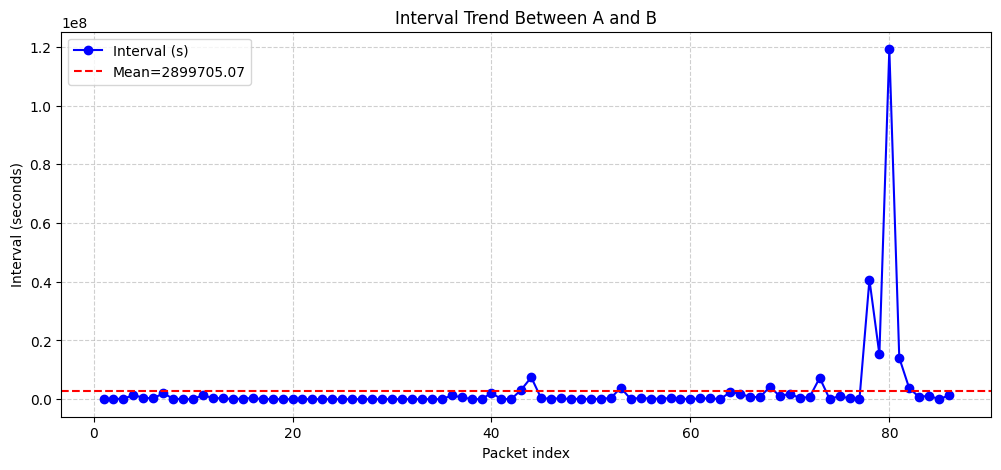

In [294]:
# Visualize timestamp trend
tsList = grhttp_df.loc[7, 'dataList']
intervals = tsList
print(calc_bowley_skewness(intervals))
print(calc_median_absolute_deviation(intervals)) 
print(calc_autocorrelation_v2(intervals))
# print(rolling_score(intervals, calc_bowley_skewness, window_size=50))
# print(rolling_score(intervals, calc_median_absolute_deviation, window_size=15))
print(rolling_score(intervals, calc_autocorrelation_v2, window_size=15, agg="max"))

# X là số thứ tự gói (1..n-1)
x = np.arange(1, len(intervals) + 1)

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 5))
plt.plot(x, intervals, marker='o', linestyle='-', color='blue', label="Interval (s)")
plt.axhline(np.mean(intervals), color='red', linestyle='--', label=f"Mean={np.mean(intervals):.2f}")

plt.xlabel("Packet index")
plt.ylabel("Interval (seconds)")
plt.title("Interval Trend Between A and B")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:

def calc_timestamp_score(tsList):
    intervals = ts_to_interval(tsList)
    bowley_skewness = calc_bowley_skewness(intervals)
    mad = calc_median_absolute_deviation(intervals)
    autocorr = calc_autocorrelation_v2(intervals)

    score = (bowley_skewness + mad + autocorr) / 3
    return score

def calc_data_size_score(byteList):
    bowley_skewness = calc_bowley_skewness(byteList)
    mad = calc_median_absolute_deviation(byteList)

    score = (bowley_skewness + mad) / 2
    return score

In [7]:
index_name = "beacon_score_test_2"

mapping = {
    "mappings": {
        "properties": {
            "srcIP": {"type": "ip"},
            "dstIP": {"type": "ip"},
            "finalScore": {"type": "float"},
            "@timestamp": {"type": "date"},
        }
    }
}

# create index safely
conn.options(ignore_status=[400]).indices.create(index=index_name, body=mapping)

# add timestamp
df.loc[:, "timestamp"] = pd.Timestamp.now(tz="Asia/Bangkok")

# prepare bulk actions
actions = [
    {
        "_index": index_name,
        "_source": {
            "srcIP": row["srcIP"],
            "dstIP": row["dstIP"],
            "finalScore": float(row["finalScore"]),
            "@timestamp": row["timestamp"].isoformat(),
        },
    }
    for _, row in df.iterrows()
]

helpers.bulk(conn, actions)

(18, [])

In [ ]:
# calculate multiple metrics, input to ML model, get output as suspicion score

In [5]:
# Tạo timestamps mỗi 12 tiếng
timestamps = pd.date_range("2025-10-01", periods=6, freq="12h", tz="Asia/Bangkok")

# Giả sử có 3 cặp IP
pairs = [
    ("10.0.0.1", "8.8.8.8"),
    ("10.0.0.2", "1.1.1.1"),
    ("10.0.0.3", "8.8.4.4"),
]

rows = []
for ts in timestamps:
    for src, dst in pairs:
        score = np.random.uniform(0, 1)  # random điểm nghi ngờ
        rows.append({"srcIP": src, "dstIP": dst, "finalScore": score, "@timestamp": ts})

df = pd.DataFrame(rows)
df

,srcIP,dstIP,finalScore,@timestamp
0,10.0.0.1,8.8.8.8,0.351629,2025-10-01 00:00:00+07:00
1,10.0.0.2,1.1.1.1,0.983086,2025-10-01 00:00:00+07:00
2,10.0.0.3,8.8.4.4,0.045161,2025-10-01 00:00:00+07:00
3,10.0.0.1,8.8.8.8,0.347826,2025-10-01 12:00:00+07:00
4,10.0.0.2,1.1.1.1,0.142505,2025-10-01 12:00:00+07:00
5,10.0.0.3,8.8.4.4,0.472700,2025-10-01 12:00:00+07:00
6,10.0.0.1,8.8.8.8,0.488997,2025-10-02 00:00:00+07:00
7,10.0.0.2,1.1.1.1,0.516808,2025-10-02 00:00:00+07:00
8,10.0.0.3,8.8.4.4,0.447075,2025-10-02 00:00:00+07:00
9,10.0.0.1,8.8.8.8,0.697940,2025-10-02 12:00:00+07:00
